Based on the insights from Data Cleaning, we keep only a subset of the columns available to avoid any leakage of future information which is unavailable when the contract is introduced for the first time in the secondary market on the P2P Lending Platform. 

In [1]:
# import the necessary packages
import numpy as np
import os
import sys
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from psynlig import plot_correlation_heatmap

from optbinning import BinningProcess
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn import preprocessing as pp
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV

(CVXPY) Jun 22 03:44:59 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jun 22 03:44:59 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.9.3963). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
df = pd.read_csv('../Data/Loan_status_Cleaned.csv')
df.shape

(50000, 15)

In [3]:
df.head()

,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,issue_d,loan_status,purpose,dti,total_acc,acc_now_delinq,pct_tl_nvr_dlq,pub_rec_bankruptcies
0,15000,36 months,7.90%,469.36,A,RENT,45000.0,Dec-2011,Fully Paid,debt_consolidation,8.48,27,0,NaN,0.0
1,16000,60 months,19.91%,423.11,E,RENT,81000.0,Dec-2011,Fully Paid,credit_card,20.52,21,0,NaN,0.0
2,7100,36 months,16.77%,252.33,D,MORTGAGE,33000.0,Dec-2011,Fully Paid,debt_consolidation,24.00,8,0,NaN,0.0
3,10000,36 months,8.90%,317.54,A,RENT,24000.0,Dec-2011,Fully Paid,debt_consolidation,7.00,21,0,NaN,0.0
4,2500,36 months,14.27%,85.78,C,RENT,49500.0,Dec-2011,Fully Paid,debt_consolidation,10.33,20,0,NaN,0.0


In [4]:
# change datatype of issue date and sort the data by issue date
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')
df.sort_values(by='issue_d', inplace=True)

In [5]:
# add macroeconomic variables
# load macroeconomic data
macro = pd.read_csv('../Data/Macro.csv')
macro['Date'] = pd.to_datetime(macro['Date'], format='%Y-%m-%d')

# merge macro data with loan data
df = df.merge(macro, how='left', left_on='issue_d', right_on='Date')

# drop Date column
df.drop('Date', axis=1, inplace=True)

df.shape

(50000, 17)

The data set contains historical data of loans on Lending Club that went into default or not. We consider default the positive class and non-default the negative class. The target is dervied from the colum 'loan_status'. The target is assumed to be default if the status is 'default' or 'charged-off'.

In [6]:
df['loan_status'].value_counts()

loan_status
Fully Paid                                             25684
Current                                                17537
Charged Off                                             6199
Late (31-120 days)                                       268
In Grace Period                                          161
Late (16-30 days)                                         48
Issued                                                    47
Does not meet the credit policy. Status:Fully Paid        43
Does not meet the credit policy. Status:Charged Off       10
Default                                                    3
Name: count, dtype: int64

In [7]:
# set the target variable as 1 if loan_status is 'Charged Off' or 'Default' or 'Does not meet the credit policy. Status:Charged Off'
df['default'] = np.where((df['loan_status'] == 'Charged Off') | 
                        (df['loan_status'] == 'Default') | 
                        (df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'), 
                        1, # postive case
                        0  # negative case
                        )

# drop loan_status column
df.drop('loan_status', axis=1, inplace=True)

df['default'].value_counts()

default
0    43788
1     6212
Name: count, dtype: int64

Target:
- default

Categorical columns:
- term
- grade
- home_ownership
- purpose

Numeric columns:
- loan_amnt
- installment
- annual_inc
- dti
- total_acc
- acc_now_delinq
- pct_tl_nvr_dlq
- GDP
- VIX

Date column:
- issue_d

# Feature Engineering

In [8]:
df['int_rate'] = df['int_rate'].str.replace('%', '').astype('float')
df['int_rate'].head()

0    15.33
1    10.59
2    17.54
3    14.38
4    14.38
Name: int_rate, dtype: float64

In [9]:
df['annual_inc'] = df['annual_inc'].astype('int')
df['annual_inc'].head()

0    86000
1    60000
2    31000
3    31500
4    21360
Name: annual_inc, dtype: int32

In [10]:
# change the type to int
df['total_acc'] = df['total_acc'].astype('int')

In [11]:
# numeric features

# replace lower or equal to 0 with NaN
df.loc[df['loan_amnt'] <= 0, 'loan_amnt'] = np.nan
df.loc[df['acc_now_delinq'] <= 0, 'acc_now_delinq'] = np.nan
df.loc[df['annual_inc'] <= 0, 'annual_inc'] = np.nan
df.loc[df['dti'] <= 0, 'dti'] = np.nan

# log transform
df['annual_inc'] = np.log1p(df['annual_inc'])
df['loan_amnt'] = np.log1p(df['loan_amnt'])
df['installment'] = np.log1p(df['installment'])
df['dti'] = np.log1p(df['dti'])

# create account delinquency ratio
df['acc_delinq_ratio'] = df['acc_now_delinq'] / df['total_acc']

# take log of total account
df['total_acc'] = np.log1p(df['total_acc'])

# drop acc_now_delinq
df.drop('acc_now_delinq', axis=1, inplace=True)

# cap interest rate at 100%
df.loc[df['int_rate'] > 100, 'int_rate'] = 100

# divide interest rate by 100
df['int_rate'] = df['int_rate'] / 100

# divide pecentage of never delinquent accounts by 100
df['pct_tl_nvr_dlq'] = df['pct_tl_nvr_dlq'] / 100

In [12]:
# move issue_d to the first column
cols = list(df.columns)
cols.remove('issue_d')
cols = ['issue_d'] + cols
df = df[cols]

# create a new column with the year of the issue date
df['year'] = df['issue_d'].dt.year

# create a new column with the month of the issue date
df['month'] = df['issue_d'].dt.month

df.head()

,issue_d,loan_amnt,term,int_rate,installment,grade,home_ownership,annual_inc,purpose,dti,total_acc,pct_tl_nvr_dlq,pub_rec_bankruptcies,GDP,VIX,default,acc_delinq_ratio,year,month
0,2007-07-01,8.294300,36 months,0.1533,4.943854,F,RENT,11.362114,credit_card,3.050220,3.637586,NaN,NaN,2.782811,16.230000,0,NaN,2007,7
1,2007-07-01,9.413363,36 months,0.1059,5.990689,C,RENT,11.002117,small_business,2.897016,3.218876,NaN,NaN,2.782811,16.230000,0,NaN,2007,7
2,2007-10-01,9.256842,36 months,0.1754,5.933014,G,RENT,10.341775,debt_consolidation,3.151453,2.772589,NaN,0.0,2.782811,18.000000,1,NaN,2007,10
3,2007-10-01,8.188967,36 months,0.1438,4.825991,E,RENT,10.357775,debt_consolidation,2.970927,2.302585,NaN,NaN,2.782811,18.000000,0,NaN,2007,10
4,2007-11-01,8.699681,36 months,0.1438,5.333588,E,RENT,9.969322,debt_consolidation,2.992226,2.772589,NaN,NaN,2.782811,18.530001,0,NaN,2007,11


In [13]:
# find observations where the year is 2020
df.loc[df['year'] == 2020].shape

(2487, 19)

In [14]:
df.set_index('issue_d', inplace=True)

In [15]:
df.index

DatetimeIndex(['2007-07-01', '2007-07-01', '2007-10-01', '2007-10-01',
               '2007-11-01', '2007-12-01', '2007-12-01', '2008-01-01',
               '2008-01-01', '2008-01-01',
               ...
               '2020-09-01', '2020-09-01', '2020-09-01', '2020-09-01',
               '2020-09-01', '2020-09-01', '2020-09-01', '2020-09-01',
               '2020-09-01', '2020-09-01'],
              dtype='datetime64[ns]', name='issue_d', length=50000, freq=None)

In [16]:
# find the number of loans issued in the last month
df.loc['2020-09'].shape

(223, 18)

Loans issued in September 2020 are used to test the portfolio strategy. To mimic a real world senario, GDP growth rate and VIX are forecasted on a six-month horizon and the portfolio composition is updated accordingly based on iterative monthly PD predictions. 

For simplicity, we assume that the time difference between when a loan is issued, purchased for the first time and available again in the secondary market is negligible. 

In [17]:
# extrat contracts in the last month
df_portfolio = df.loc['2020-09'].copy()

df_portfolio.shape

(223, 18)

In [18]:
# remove loans that belong to the portfolio

print(df.shape)
df.drop(df_portfolio.index, inplace=True)
print(df.shape)

(50000, 18)
(49777, 18)


# Train-Test Split

In [19]:
df['year'].value_counts()

year
2019    8758
2018    8536
2017    7575
2016    7484
2015    7176
2014    4032
2013    2330
2020    2264
2012     911
2011     354
2010     207
2009      96
2008      47
2007       7
Name: count, dtype: int64

Based on the count of observations year by year, the test set includes years 2019 and 2020, while the train set includes all the years before. This ensures a split of about 80%-20%.

In [20]:
# define train and test sets
train_set = df.iloc[(df.index.year < 2019)]
test_set = df.iloc[(df.index.year >= 2019)]


print(train_set.shape)
print(test_set.shape)

(38755, 18)
(11022, 18)


# Exploratory Data Analysis

In [21]:
# move default column to the front
cols = list(train_set.columns)
cols.remove('default')
cols = ['default'] + cols
train_set = train_set[cols]

In [22]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
default,38755.0,0.153916,0.360873,0.000000,0.000000,0.000000,0.000000,1.000000
loan_amnt,38755.0,9.404916,0.707190,6.216606,8.987322,9.472782,9.903538,10.596660
int_rate,38755.0,0.130867,0.048626,0.053100,0.094900,0.126200,0.159900,0.309900
installment,38755.0,5.912835,0.657677,2.882004,5.534022,5.941013,6.388511,7.336859
annual_inc,38722.0,11.095694,0.559738,0.693147,10.736418,11.082158,11.440366,15.761421
dti,38697.0,2.846732,0.563072,0.019803,2.553344,2.937043,3.240637,6.907755
total_acc,38755.0,3.106638,0.501225,1.098612,2.772589,3.135494,3.465736,4.727388
pct_tl_nvr_dlq,37551.0,0.940605,0.090316,0.125000,0.912000,0.984000,1.000000,1.000000
pub_rec_bankruptcies,38733.0,0.129786,0.371120,0.000000,0.000000,0.000000,0.000000,8.000000
GDP,38755.0,2.145234,0.513475,-2.599888,1.841875,2.241921,2.287776,2.782811


In [23]:
numeric_columns = train_set.select_dtypes(include=[np.number]).columns
numeric_columns

Index(['default', 'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'total_acc', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'GDP', 'VIX',
       'acc_delinq_ratio', 'year', 'month'],
      dtype='object')

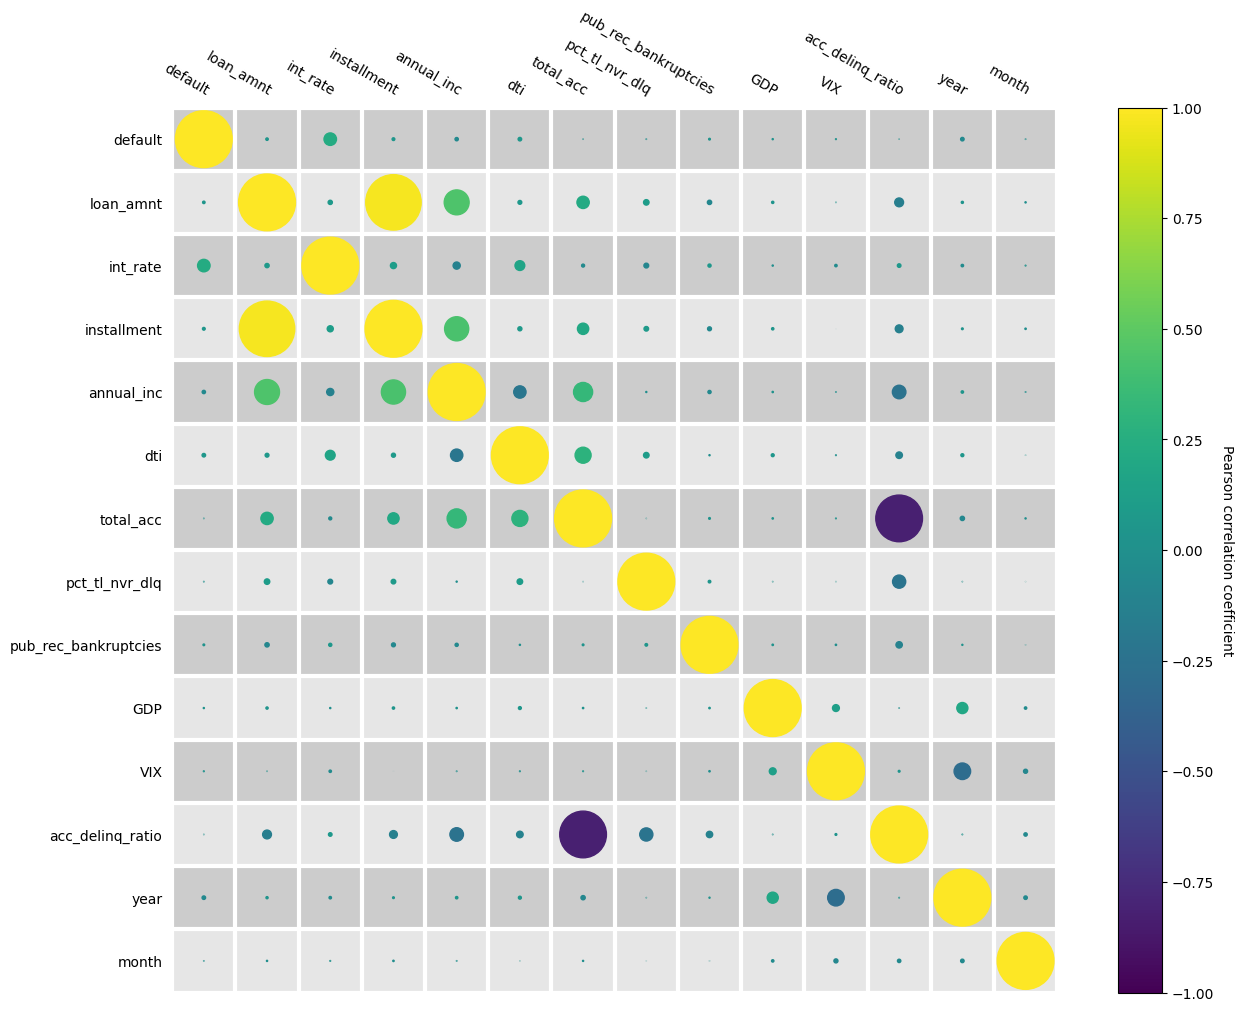

In [24]:
kwargs = {
    'heatmap': {
        'vmin': -1,
        'vmax': 1,
        'cmap': 'viridis',
    },
    'figure': {
        'figsize': (14, 10),
    },
}

plot_correlation_heatmap(train_set[numeric_columns], bubble=True, annotate=False, **kwargs)
plt.show()

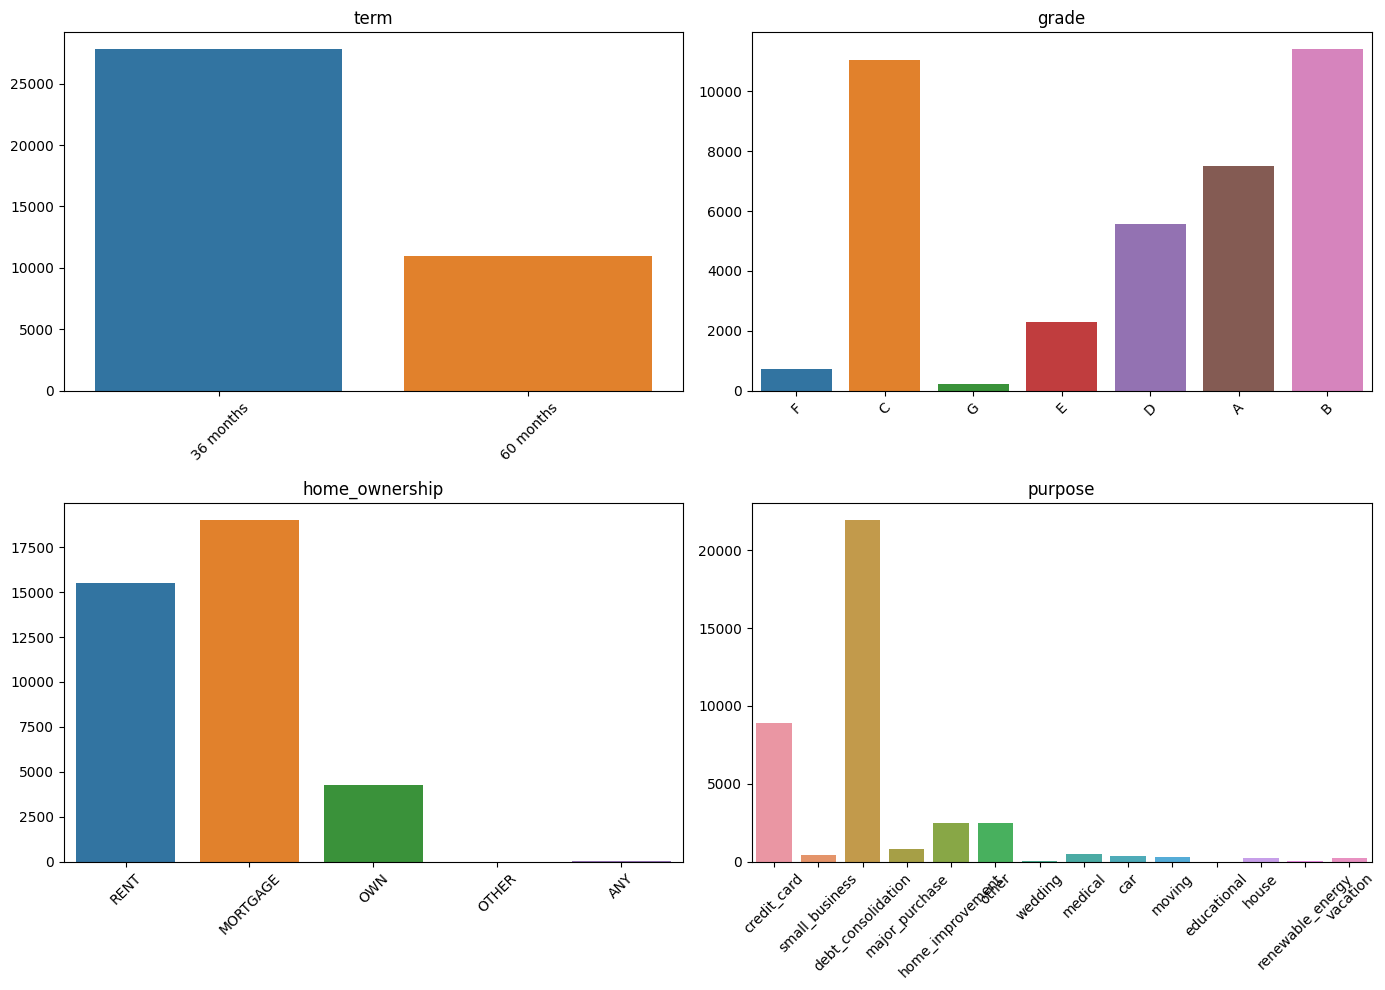

In [25]:
# boxplot of categorical features
categorical_columns = train_set.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=train_set, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [31]:
# let's see the effect of Binning Process on the categorical features
X = train_set[categorical_columns]
y = train_set['default']


# define the binning process
binning_process = BinningProcess(variable_names=categorical_columns.tolist())

# fit the binning process
binning_process.fit(X, y)

# transform the data
X_binned = binning_process.transform(X)

X_binned

,term,grade,home_ownership,purpose
issue_d,,,,
2007-07-01,0.184132,-1.079458,-0.179776,0.150884
2007-07-01,0.184132,-0.124870,-0.179776,-0.086163
2007-10-01,0.184132,-1.079458,-0.179776,-0.086163
2007-10-01,0.184132,-1.079458,-0.179776,-0.086163
2007-11-01,0.184132,-1.079458,-0.179776,-0.086163
...,...,...,...,...
2018-12-01,0.184132,1.256775,-0.179776,-0.086163
2018-12-01,0.184132,1.256775,0.031496,-0.086163
2018-12-01,0.184132,1.256775,-0.179776,-0.086163


In [32]:
binning_process.information(print_level=1)

optbinning (Version 0.19.0)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                  38755
    Number of variables                    4
    Target type                       binary

    Number of numerical                    0
    Number of categorical                  4
    Number of selected                     4

  Time                                0.2623 sec



In [33]:
binning_process.summary()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,term,categorical,OPTIMAL,True,2,0.070386,0.008758,0.123779,0.156192
1,grade,categorical,OPTIMAL,True,5,0.420413,0.05019,0.343512,0.891503
2,home_ownership,categorical,OPTIMAL,True,3,0.025332,0.003163,0.08276,0.076658
3,purpose,categorical,OPTIMAL,True,4,0.014362,0.001793,0.058683,0.028465


In [35]:
optb = binning_process.get_binned_variable("term")
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[ 36 months],27786,0.716966,24134,3652,0.131433,0.184132,0.022792,0.002845
1,[ 60 months],10969,0.283034,8656,2313,0.210867,-0.384507,0.047594,0.005913
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,38755,1.000000,32790,5965,0.153916,,0.070386,0.008758


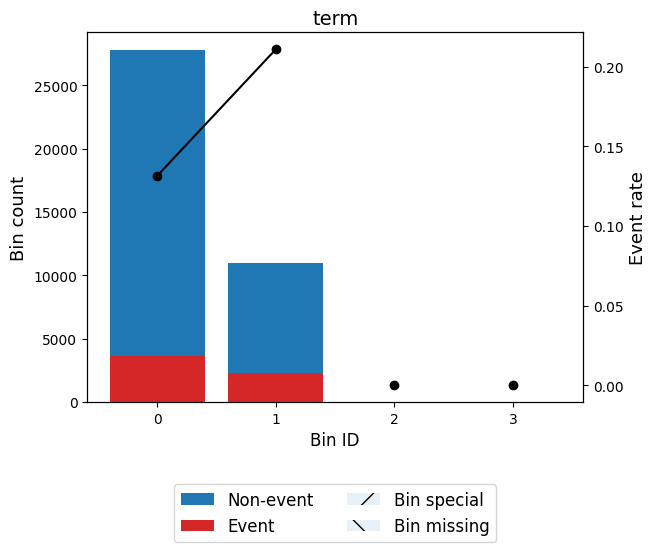

In [36]:
optb.binning_table.plot(metric="event_rate")

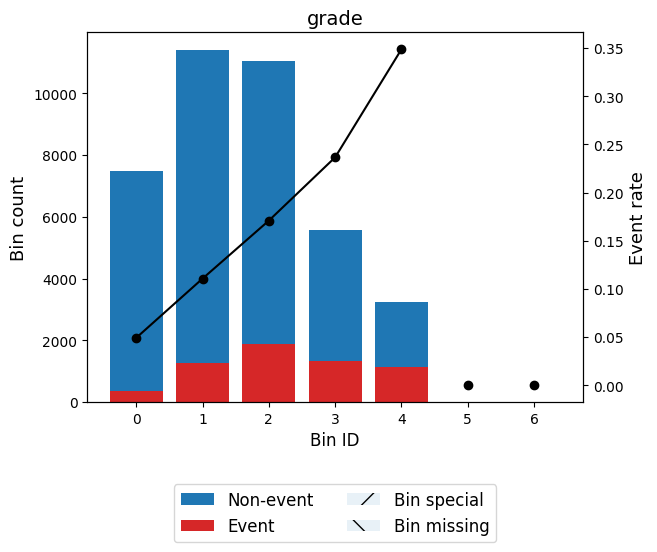

In [38]:
optb = binning_process.get_binned_variable("grade")
optb.binning_table.plot(metric="event_rate")

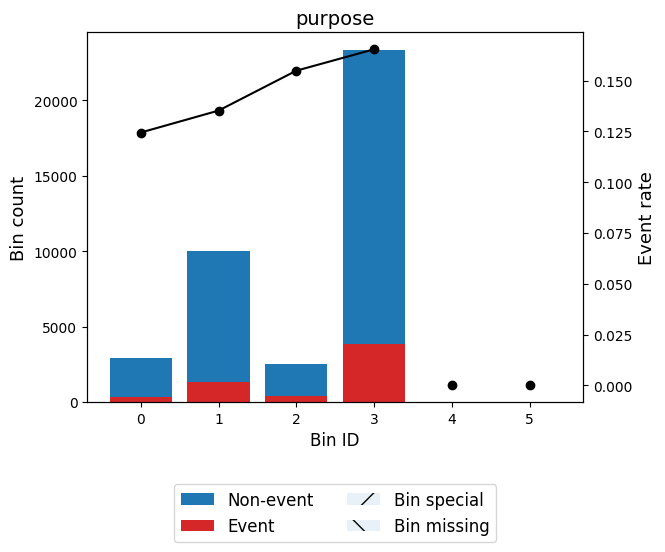

In [39]:
optb = binning_process.get_binned_variable("purpose")
optb.binning_table.plot(metric="event_rate")

Optimal Binning seems to work fine on categorical predictors. Therefore, we keep this method to encode categorical predictors in the pipeline.

# Cross-Validation Split

In [ ]:
cv = TimeSeriesSplit(n_splits=5)

# Preprocessing Steps

In [ ]:
# define the pipeline for numeric columns
numeric_pipeline = Pipeline([
    ('scaler', pp.StandardScaler())
])

# define the pipeline for categorical columns
categorical_pipeline = Pipeline([
    ('encoder', BinningProcess(variable_names=categorical_columns.tolist()))
])

# define the preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_columns),
    ('cat', categorical_pipeline, categorical_columns)
])

preprocessor 

# Pipeline

In [ ]:
pipe = Pipeline([
    ('preprocessor', BinningProcess(variable_names=categorical_columns.tolist())),
    ('classifier', RandomForestClassifier())
])

# Hyper-parameter Tuning

In [ ]:
grid = {'max_depth': [8, 15, None], 
        'max_features': [0.3, 0.5, None],
        'n_estimators': [50, 100, 200]
        }

gs = GridSearchCV(pipe, grid, cv=cv, scoring='f1', n_jobs=-1)

X = train_set.drop('default', axis=1)
y = train_set['default']

gs.fit(X, y)

print(gs.best_params_)